# 👨‍🎤👨‍⚖ actor-critic for llvm-autophase task

## Problem description:

This task in based on [CompilerGym](https://compilergym.com/) environment with is designed to make compilers closer to ml optimizations. It allows ML researchers to interact with important compiler optimization problems in a language and vocabulary with which they are comfortable, and provides a toolkit for systems developers to expose new compiler tasks for ML research. 

We will focus on *llvm-autophase* task. 

<<description of *llvm-autophase* task>>
The llvm-ic-v0 environment exposes LLVM's optimizing passes as a set of actions that can be applied to a particular program. The goal of the agent is to select the sequence of optimizations that lead to the greatest reduction in instruction count in the program being compiled

Compilers frequently package individual transformations as “optimization passes” which are then applied in a sequential order. Usually this order is fixed (e.g. [real world example](https://github.com/llvm/llvm-project/blob/71a8e4e7d6b947c8b954ec0763ff7969b3879d7b/llvm/lib/Transforms/IPO/PassManagerBuilder.cpp#L517-L922)). The CompilerGym LLVM environment replaces that fixed order with a sequential decision process where any pass may be applied at any stage.

Questions from Albina:
- what is LLVM-IR?
- what is LLVM statement?
- what are LLVM optimization levels: -O3, and -Oz?

### Overview of llvm environment in CompilerGym

Here just some notes. For more go to [full overview](https://compilergym.com/llvm/index.html).

**Datasets.**

Load from model or add your own via `env.make_benchmark()` API.

**Observation Spaces.**

Here you can choose from a bunch of ways to record the "current state" of the compiler:


- LLVM-IR (Denis help, what it is???) `ir`
- [InstCount](https://compilergym.com/llvm/index.html#instcount) `ic`
    - 70-dimension integer feature vector in the range [0,∞]
    - the total number of instructions
    - the total number of basic blocks
    - the total number of functions
    - The remaining features are the number of instructions of each of the 67 different types in the program.
- [Autophase](https://compilergym.com/llvm/index.html#autophase) `autophase`
    - 56-dimension integer feature vector summarizing the static LLVM-IR representation
- [Inst2vec](https://compilergym.com/llvm/index.html#inst2vec)
    - represents LLVM-IR as sequence of embedding vectors
    - one vector = one LLVM statement (ex. `opaque = type opaque` or `ret i32 <%ID>`)
    - embeddings were trained offline on a large corpus of LLVM-IR 
    - shape of observation: (num_statements, 200)
- [ProGraML](https://compilergym.com/llvm/index.html#programl)
    - graph-based representation of LLVM-IR which includes `control-flow`, `data-flow`, and `call-flow`
- [Hardware Information](https://compilergym.com/llvm/index.html#hardware-information)
    - JSON dictionary, extracted using the cpuinfo library
    - example: `{'cores_count': 8, 'l1d_cache_count': 8, ...}`
- [Cost Models](https://compilergym.com/llvm/index.html#cost-models)
    - ??? don`t understand 
    - several variants of `IrInstructionCount` and `ObjectTextSize` 
- [Runtime](https://compilergym.com/llvm/index.html#runtime)
    - `isRunnable`, `Runtime`
    - only Experimental API!
- [Build Time](https://compilergym.com/llvm/index.html#build-time)
    - `isBuildable`, `Buildtime`
    - also only Experimental API!

[**Reward Spaces.**](https://compilergym.com/llvm/index.html#reward-spaces)

Reward is the value used to optimize our model at step. Reward navigates model to become better. In CompilerGym reward is constructured from `cost function`.
$$\text{reward} (\text{current\_step}) = \text{cost} (\text{prev\_step}) - \text{cost} (\text{current\_step})$$ 
You can select one of the following cost functions as your reward function:

- [IR Instruction Count](https://compilergym.com/llvm/index.html#ir-instruction-count)
    - The number of LLVM-IR instructions in the program can be used as a reward signal either using the raw change in instruction count (IrInstructionCount), or by scaling the changes in instruction count to the improvement made by the baseline -O3 or -Oz LLVM pipelines. 
    - fast to evaluate, deterministic, and platform-independent, but is not a measure of true codesize reduction as it does not take into account the effects of lowering.
- [Codesize](https://compilergym.com/llvm/index.html#codesize)
    - `ObjectTextSizeBytes` (the size of the `.TEXT` section of the module after lowering to an object file, before linking)
    - more expensive to compute than `IrInstructionCount`


[**Action Space.**](https://compilergym.com/llvm/index.html#action-space)

Actions in this environment are set of discrete transforms that can be applied.

For example:
- overall we have 124 otimizations in ... env (eg.: ...)
- 3 loop unrolling transfroms [LoopUnrollingEnv](https://github.com/facebookresearch/CompilerGym/tree/development/examples/example_unrolling_service) 
    - `-loop-unroll -unroll-count=2`
    - `-loop-unroll -unroll-count=4`
    - `-loop-unroll -unroll-count=8`
- we can limit action space like [here](https://github.com/ymahlau/ppo_compiler_gym/blob/72c08d86e4c96ed1e4579e5a00b9377e556609ab/llvm_wrapper.py)

**OVERALL.**

You can use one of preinstalled envs (with already selected action, observation and reward spaces) or prepare your own one.



TO ADD:
- passage about `env.close()`
- 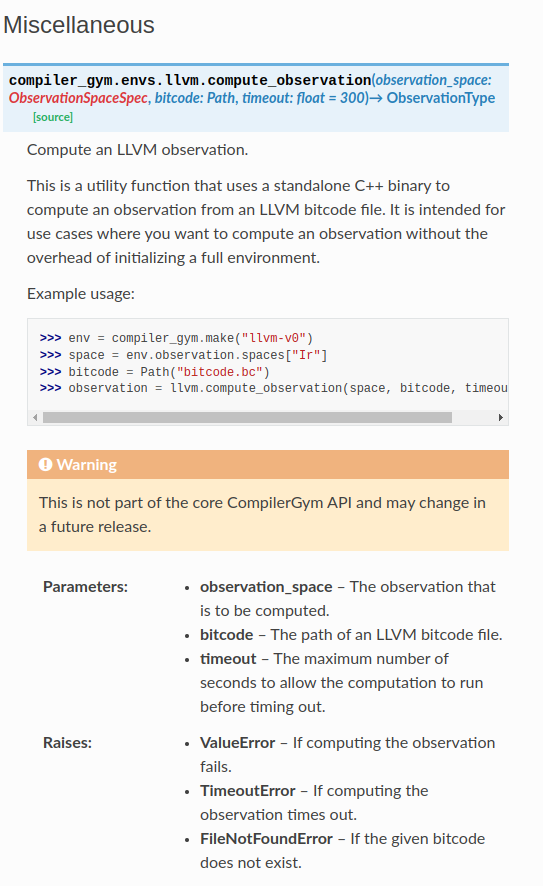
- разобраться с validate:
    - `python -m compiler_gym.bin.validate --env=llvm-ic-v0 results_temp.csv`
- Denis: how to switch between benchmarks in one training?
    - answer from [top1 of CommpilerGym Leaderboard](https://github.com/ymahlau/ppo_compiler_gym/blob/72c08d86e4c96ed1e4579e5a00b9377e556609ab/llvm_wrapper.py)
```
def switch_benchmark(self):
    idx = random.randint(0, -1 + len(self.benchmarks))
    print("Switched to {0}".format(self.benchmarks[idx]))
    self.env.close()
    self.env = gym.make("llvm-autophase-ic-v0", benchmark="cbench-v1/{0}".format(self.benchmarks[idx]))
```

In [4]:
# test different observation spaces [task can be to find best observation space for the algorithm]

In [2]:
# test different reward spaces

In [3]:
# show action space

In [79]:
import gym
import compiler_gym

env = compiler_gym.make("llvm-ic-v0")
"""sample llvm env
    - no selected observation space
    - ic (instruction count) reward space
    - action space: 124 flags"""

# env = compiler_gym.make("llvm-autophase-ic-v0")
# env = compiler_gym.make(
#     "llvm-v0",                           # selects the compiler to use
#     benchmark="cbench-v1/qsort",         # selects the program to compile
#     observation_space="Autophase",       # selects the observation space
#     reward_space="IrInstructionCountOz",)


In [78]:
env.close()

In [80]:
env.reset()

In [81]:
env.step(env.action_space.sample())

(None, 0.0, False, {'action_had_no_effect': False, 'new_action_space': False})

In [82]:
# list of all possible observations
env.observation

ObservationView[Autophase, AutophaseDict, Bitcode, BitcodeFile, Buildtime, CpuInfo, Inst2vec, Inst2vecEmbeddingIndices, Inst2vecPreprocessedText, InstCount, InstCountDict, InstCountNorm, InstCountNormDict, Ir, IrInstructionCount, IrInstructionCountO0, IrInstructionCountO3, IrInstructionCountOz, IrSha1, IsBuildable, IsRunnable, LexedIr, LexedIrTuple, ObjectTextSizeBytes, ObjectTextSizeO0, ObjectTextSizeO3, ObjectTextSizeOz, Programl, ProgramlJson, Runtime, TextSizeBytes, TextSizeO0, TextSizeO3, TextSizeOz]

In [83]:
env.observation['Programl']

In [84]:
env.reward_space

IrInstructionCountOz

In [95]:
env.action_space

Commandline([-add-discriminators -adce -aggressive-instcombine -alignment-from-assumptions -always-inline -argpromotion -attributor -barrier -bdce -break-crit-edges -simplifycfg -callsite-splitting -called-value-propagation -canonicalize-aliases -consthoist -constmerge -constprop -coro-cleanup -coro-early -coro-elide -coro-split -correlated-propagation -cross-dso-cfi -deadargelim -dce -die -dse -reg2mem -div-rem-pairs -early-cse-memssa -early-cse -elim-avail-extern -ee-instrument -flattencfg -float2int -forceattrs -inline -insert-gcov-profiling -gvn-hoist -gvn -globaldce -globalopt -globalsplit -guard-widening -hotcoldsplit -ipconstprop -ipsccp -indvars -irce -infer-address-spaces -inferattrs -inject-tli-mappings -instsimplify -instcombine -instnamer -jump-threading -lcssa -licm -libcalls-shrinkwrap -load-store-vectorizer -loop-data-prefetch -loop-deletion -loop-distribute -loop-fusion -loop-guard-widening -loop-idiom -loop-instsimplify -loop-interchange -loop-load-elim -loop-predicati

In [85]:
env.observation_space_spec

In [86]:
env.reward.__dict__

{'spaces': {'IrInstructionCount': IrInstructionCount,
  'IrInstructionCountNorm': IrInstructionCountNorm,
  'IrInstructionCountO3': IrInstructionCountO3,
  'IrInstructionCountOz': IrInstructionCountOz,
  'ObjectTextSizeBytes': ObjectTextSizeBytes,
  'ObjectTextSizeNorm': ObjectTextSizeNorm,
  'ObjectTextSizeO3': ObjectTextSizeO3,
  'ObjectTextSizeOz': ObjectTextSizeOz,
  'TextSizeBytes': TextSizeBytes,
  'TextSizeNorm': TextSizeNorm,
  'TextSizeO3': TextSizeO3,
  'TextSizeOz': TextSizeOz},
 'previous_action': None,
 '_observation_view': ObservationView[Autophase, AutophaseDict, Bitcode, BitcodeFile, Buildtime, CpuInfo, Inst2vec, Inst2vecEmbeddingIndices, Inst2vecPreprocessedText, InstCount, InstCountDict, InstCountNorm, InstCountNormDict, Ir, IrInstructionCount, IrInstructionCountO0, IrInstructionCountO3, IrInstructionCountOz, IrSha1, IsBuildable, IsRunnable, LexedIr, LexedIrTuple, ObjectTextSizeBytes, ObjectTextSizeO0, ObjectTextSizeO3, ObjectTextSizeOz, Programl, ProgramlJson, Runtim

In [87]:
env.reward['IrInstructionCount']

0.0

In [88]:
env.reward['ObjectTextSizeBytes']

0.0

In [89]:
env.benchmark

benchmark://cbench-v1/qsort

In [9]:
help(env)

Help on LlvmEnv in module compiler_gym.envs.llvm.llvm_env object:

class LlvmEnv(compiler_gym.service.client_service_compiler_env.ClientServiceCompilerEnv)
 |  LlvmEnv(*args, benchmark: Union[str, compiler_gym.datasets.benchmark.Benchmark, NoneType] = None, datasets_site_path: Optional[pathlib.Path] = None, **kwargs)
 |  
 |  A specialized ClientServiceCompilerEnv for LLVM.
 |  
 |  This extends the default :class:`ClientServiceCompilerEnv
 |  <compiler_gym.envs.ClientServiceCompilerEnv>` environment, adding extra LLVM
 |  functionality. Specifically, the actions use the :class:`CommandlineFlag
 |  <compiler_gym.spaces.CommandlineFlag>` space, which is a type of
 |  :code:`Discrete` space that provides additional documentation about each
 |  action, and the :meth:`LlvmEnv.commandline()
 |  <compiler_gym.envs.LlvmEnv.commandline>` method can be used to produce an
 |  equivalent LLVM opt invocation for the current environment state.
 |  
 |  Method resolution order:
 |      LlvmEnv
 |   